## Objective

Using L1 Lasso regularization, let's run a GridSearch to find the best model for each category. We should get better performance for most of the models, and see more useful feature subset selection.

## Conclusion

Our highest $R^2$ for each of the models by category is 0.43, which is worse than the $R^2$ of our overall model, 0.56. I'm not sure why, but for now I will table the idea of sub-models.

Maybe models for groups of categories might be appropriate.

In [6]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
from tqdm import tqdm

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")
# rcParams['figure.figsize'] = 20, 5

import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))
from helper_functions import dummify_cols_and_baselines, make_alphas, remove_outliers_by_type, choose_race_mode, transform_school

In [7]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

## Removing outliers

A standard procedure is to remove values further than 3 standard deviations from the mean. Since I have so many low values and some very high values, I anecdotally think that the low values are very likely to be true, and the high values not so much.

So, I will remove values further than 3 SDs from the median, by type.

Ideally, I would take into account the time dimension. I would like to do so given more time.

In [8]:
df_outliers_removed = remove_outliers_by_type(df_orig, y_col='COMPLETION_HOURS_LOG_10')
df_outliers_removed.shape

../preprocessing/helper_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[pd.np.abs(group - group.median()) > stds * group.std()] = pd.np.nan
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.where(-key, value, inplace=True)


(508653, 40)

I'm removing ~1.5% of my rows.

## Transformations

In [9]:
df2 = transform_school(df_outliers_removed)
df2.shape

../preprocessing/helper_functions.py:53: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  df.school = df.school.str.extract(r'(\d\d?)').astype(int)


(508653, 40)

## Choosing columns

In [11]:
cols_orig_dataset = ['COMPLETION_HOURS_LOG_10', 'TYPE', 'SubmittedPhoto', 'Property_Type', 'Source', 'neighborhood_from_zip']
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']
cols_engineered = ['queue_wk', 'queue_wk_open', 'is_description']

In [12]:
df = df2[cols_orig_dataset + cols_census + cols_engineered]

## Dummify

In [13]:
cols_to_dummify = [i for i in df.dtypes[df.dtypes == object].index if i != 'TYPE']
cols_to_dummify

['Property_Type', 'Source', 'neighborhood_from_zip', 'housing']

In [14]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df, cols_to_dummify)

other is baseline 0 4
Twitter is baseline 1 4
West Roxbury is baseline 2 4
rent is baseline 3 4


In [15]:
df_dummified.shape

(508653, 54)

## Running model

In [16]:
# these categs have less than 100 total issues
categ_blacklist = set(['Fire in Food Establishment',
 'BWSC Pothole',
 'Animal Lost',
 'Carbon Monoxide',
 'City/State Snow Issues',
 'Bicycle Issues',
 'Illegal Use',
 'No Utilities Residential - Gas',
 'Cemetery Maintenance Request',
 'Snow Removal',
 'Mosquitoes (West Nile)',
 'Roadway Flooding',
 'Illegal Vending',
 'Occupying W/Out A Valid CO/CI',
 'Bridge Maintenance',
 'Billing Complaint',
 'Phone Bank Service Inquiry',
 'Animal Noise Disturbances',
 'Planting',
 'No Price on Gas/Wrong Price',
 'Rat Bite',
 'Item Price Missing',
 'Student Overcrowding',
 'Scanning Overcharge',
 'Big Buildings Online Request',
 'Checkin',
 'Municipal Parking Lot Complaints',
 'Valet Parking Problems',
 'Poor Ventilation',
 'OCR Metrolist',
 'No Utilities - Food Establishment - Sewer',
 'No Utilities - Food Establishment - Water',
 'Unit Pricing Wrong/Missing',
 'Snow/Ice Control',
 'Fire Department Request',
 'Loud Parties/Music/People',
 'No Utilities - Food Establishment - Flood',
 'Sign Shop WO',
 'Walk-In Service Inquiry',
 'No Utilities - Food Establishment - Electricity',
 'Product Short Measure',
 'Private Parking Lot Complaints',
 'Alert Boston',
 'Rooftop & Mechanical Disturbances',
 'Water in Gas - High Priority',
 'Dumpster & Loading Noise Disturbances',
 'CE Collection',
 'One Boston Day',
 'WC Call Log',
 'Undefined Noise Disturbance',
 'Idea Collection',
 'Yardwaste Asian Longhorned Beetle Affected Area',
 'Scale Not Visible',
 'Follow-Up',
 'News Boxes',
 'Automotive Noise Disturbance',
 'Downed Wire',
 'Public Events Noise Disturbances',
 'Senior Shoveling',
 'HP Sign Application New',
 'Heat/Fuel Assistance',
 'Knockdown Replacement',
 'Utility Casting Repair',
 'Transfer Not Completed',
 'New Tree Warrantee Inspection',
 'HP Sign Application Renewal',
 'ADA'])

In [17]:
# top 10 r2s

whitelist = set(['Recycling Cart Return',
 'Recycling Cart Inquiry',
 'Misc. Snow Complaint',
 'Request for Snow Plowing',
 'Notification',
 'Illegal Auto Body Shop',
 'Request for Snow Plowing (Emergency Responder)',
 'Empty Litter Basket',
 'Electrical',
 'Needle Pickup'])

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
categs = set(df_dummified.TYPE.drop_duplicates().tolist())

In [20]:
df.COMPLETION_HOURS_LOG_10.describe()

count    508653.000000
mean          1.719541
std           1.117803
min          -2.954243
25%           1.354471
50%           1.865834
75%           2.374271
max           4.662771
Name: COMPLETION_HOURS_LOG_10, dtype: float64

In [ ]:
df[df.TYPE == 'Recycling Cart Return'].COMPLETION_HOURS_LOG_10.describe()

In [73]:
def run_gridsearch(df_orig, categ):
    df = df_orig[df_orig.TYPE == categ].drop('TYPE', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('COMPLETION_HOURS_LOG_10', axis=1), 
        df.COMPLETION_HOURS_LOG_10, 
        test_size=0.2, 
        random_state=300
    )

    pipe = make_pipeline(StandardScaler(), LassoCV())
    # cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=300)

    params = {'lassocv__alphas': make_alphas(-4, 4)}
    model = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5, verbose=False)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    results = pd.DataFrame(model.cv_results_).T
    best_estimator = model.best_estimator_.steps[-1][-1]
    rmse = mean_squared_error(y_test, y_pred)**0.5
    
    return { categ: {
        'result': results,
        'best_params': model.best_params_,
        'best_estimator': best_estimator,
        'best_score': model.best_score_,
        'rmse': rmse
    }}

In [89]:
results = {}
categs_in_question = categs.union(whitelist) - categ_blacklist
# categs_in_question = whitelist
# categs_in_question = ['Illegal Auto Body Shop']

for categ in tqdm(categs_in_question):
    result = run_gridsearch(df_dummified, categ)
    results.update(result)

100%|██████████| 125/125 [10:45<00:00,  4.84s/it]


In [102]:
def make_results_table(results_dict):
    r = {}

    for categ, result in results.iteritems():
        r[categ] = result['result'].loc['mean_test_score'].max()

    df_num_issues = df[['TYPE', 'Source']].groupby('TYPE').count().reset_index()
    df_num_issues.columns = ['categ', 'num_issues']

    df_results = pd.DataFrame(r.items(), columns=['categ', 'r2'])
    df_results['rmse'] = df_results.categ.map(lambda categ: results[categ]['rmse'])
    df_results = df_results.sort_values('rmse')

    ans = df_results.merge(df_num_issues, on='categ', how='left')
    return ans

In [105]:
df_results = make_results_table(results)
df_results.head()

,categ,r2,rmse,num_issues
0,Unsanitary Conditions - Employees,-0.049050,0.290990,192
1,Schedule a Bulk Item Pickup SS,0.077196,0.294869,20925
2,Food Alert - Confirmed,0.015117,0.318033,340
3,Notification,0.368611,0.327298,4599
4,Schedule a Bulk Item Pickup,0.098656,0.328038,62975


In [106]:
# import pickle
# with open('../data/lasso_q2_ea_model_results.pkl','w') as f:
#     pickle.dump(results, f)

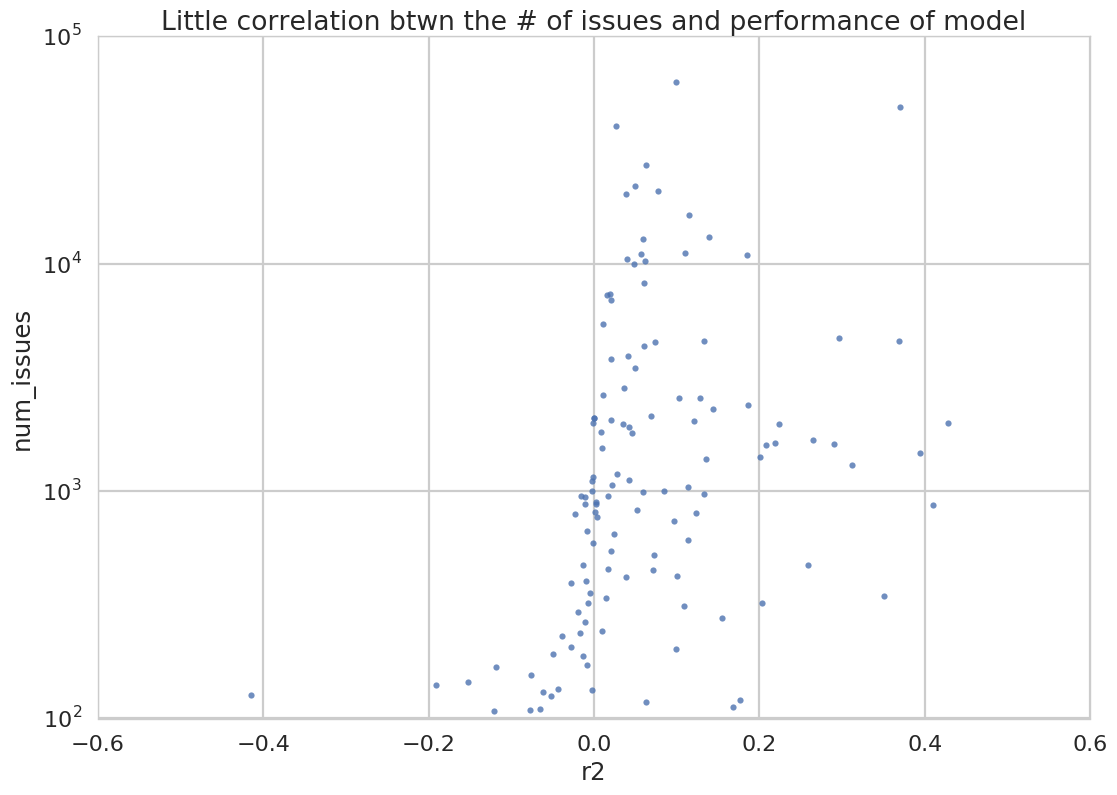

In [121]:
ax = sns.regplot(x='r2', y='num_issues', data=df_results, fit_reg=False)
ax.set_yscale('log')
ax.set_title('Little correlation btwn the # of issues and performance of model');

### How many coefficients go to 0?

In [114]:
model_coefs = results["Schedule a Bulk Item Pickup SS"]['best_estimator'].coef_
cols = df_dummified.head(1).drop(['TYPE', 'COMPLETION_HOURS_LOG_10'], axis=1).columns

In [109]:
pd.Series(model_coefs).describe()

count    52.000000
mean     -0.004220
std       0.012915
min      -0.039342
25%      -0.011746
50%      -0.000657
75%       0.001593
max       0.039918
dtype: float64

In [113]:
len(cols[model_coefs != 0])

42

In [115]:
len(cols)

52

In [117]:
results["Schedule a Bulk Item Pickup SS"]['best_params']

{'lassocv__alphas': [0.00030000000000000003]}

10 are 0 at `α=0.0003`.

### Looking at most important coefs for completion time for `Schedule a Bulk Item Pickup SS`

In [119]:
coef_values = pd.DataFrame({
    'name': cols,
    'coef': model_coefs
})
coef_values['coef_abs'] = pd.np.abs(coef_values.coef)
coef_values.sort_values('coef_abs', ascending=False)

,coef,name,coef_abs
23,3.991777e-02,queue_wk_open,3.991777e-02
49,-3.934187e-02,neighborhood_from_zip_South End,3.934187e-02
46,-2.814619e-02,neighborhood_from_zip_Roxbury,2.814619e-02
31,-2.586582e-02,neighborhood_from_zip_Back Bay,2.586582e-02
32,-2.365873e-02,neighborhood_from_zip_Beacon Hill,2.365873e-02
43,-2.256424e-02,neighborhood_from_zip_Mission Hill,2.256424e-02
44,-1.990763e-02,neighborhood_from_zip_North End,1.990763e-02
45,-1.975431e-02,neighborhood_from_zip_Roslindale,1.975431e-02
34,-1.882879e-02,neighborhood_from_zip_Charlestown,1.882879e-02
47,-1.788583e-02,neighborhood_from_zip_South Boston,1.788583e-02
